In [1]:
import torch
import math

import matplotlib.pyplot as plt


torch.set_grad_enabled(False)


### Data Generation

In [2]:
def generate_disc_set(nb):
    input_ = torch.empty(nb, 2).uniform_(0,1)
    target_ = torch.empty(nb).long()
    
    for i in range(nb):
        if (torch.norm(input_[i]) < math.sqrt(1/(2*math.pi))):
            target_[i] = 1
        else : target_[i] = 0
    
    return input_, target_

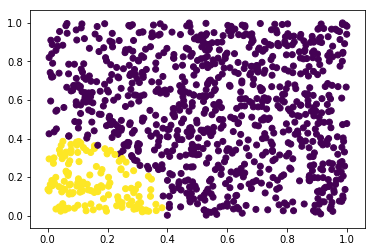

In [3]:
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

plt.scatter(train_input[:,0],train_input[:,1], c = train_target)
plt.show()

In [4]:
def normalize(input_):
    mean = input_.mean(0)
    std = input_.std(0)
    normalized_input_ = (input_-mean)/std
    return normalized_input_, mean, std

In [5]:
train_input,mean,std = normalize(train_input)

### Activation functions

In [6]:
def Tanh_fun(x):
    return x.tanh()
    
def d_Tanh(x):
    return (1 - torch.pow(Tanh_fun(x), 2))

def ReLU_fun(x):
    return x * (x > 0).float()

def d_ReLU(x):
    return 1. * (x > 0).float()

### Loss

In [7]:
def LossMSE(v, t):
    return torch.sum(torch.pow(t-v, 2)).item()
    
def d_LossMSE(v, t):
    return (2*(v-t)).item()

### Forward and backward passes

In [8]:
class Module(object):
    
    def forward_pass(self, *_input_):
        raise NotImplementedError

    def backward_pass(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []
    
    def update(self, eta):
        return [] 
    
    def zerograd(self):
        return []    

In [9]:
class Linear(Module):
    
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.counter = 0;
        
        #self.w = torch.empty(out_features,in_features).normal_(0,1e-6)
        self.w = torch.rand(out_features, in_features)
        #self.b = torch.empty(out_features).normal_(0,1e-6) # Think about Xavier normalization, calculate gain 
        #(depending on the activation fct the way the network saturates changes)
        self.b = torch.rand(out_features)
        
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())
        self.cache_forward = None
    
    def forward_pass(self, _input_):
        self.cache_forward = _input_
        return self.w @ _input_ + self.b

    def backward_pass(self, gradwrtoutput):
        self.dl_dw += gradwrtoutput.view(self.out_features,1) @ self.cache_forward.view(1,self.in_features)
        self.dl_db += gradwrtoutput
        self.counter += 1
        self.cache_forward = None
        return gradwrtoutput@self.w
        
    def param(self):
        return [(self.w, self.dl_dw), (self.b, self.dl_db)]
    
        
    def update(self, eta):
        self.w -= eta * (self.dl_dw/self.counter)
        self.b -= eta * (self.dl_db/self.counter)
        
    def zerograd(self):
        self.dl_dw = torch.zeros(self.w.size())
        self.dl_db = torch.zeros(self.b.size())
        self.counter = 0;
      
        

class ReLU(Module):
    
    def __init__(self):
        super(ReLU, self).__init__()
        self.cache_forward = None
    
    def forward_pass(self, _input_):
        self.cache_forward = _input_
        return (ReLU_fun(_input_))

    def backward_pass(self, gradwrtoutput):
        dl_s = d_ReLU(self.cache_forward) * gradwrtoutput
        self.cache_forward = None
        #dl_s = dl_s.view(gradwrtoutput.size(1), -1)
        return dl_s
        

class Tanh(Module):
    
    def __init__(self):
        super(Tanh, self).__init__()
        self.cache_forward = None
    
    def forward_pass(self, _input_):
        self.cache_forward = _input_
        return (Tanh_fun(_input_))

    def backward_pass(self, gradwrtoutput):
        dl_s = d_Tanh(self.cache_forward) * gradwrtoutput
        self.cache_forward = None
        #dl_s = dl_s.view(gradwrtoutput.size(1), -1)
        return dl_s
    
# Need to add Sigmoid? 
        

In [10]:
class Sequential(Module):
    
    def __init__(self, *args):
        super(Sequential, self).__init__()
        self.modules = []
        self.forward = None
        self.backward = None
        for module in args:
            self.modules.append(module)
    
    def forward_pass(self, _input_):
        self.forward = _input_
        for module in self.modules:
            self.forward = module.forward_pass(self.forward)
        return torch.argmax(self.forward).item()
            
    def backward_pass(self, target):
        self.backward = d_LossMSE(torch.argmax(self.forward), target)# has to be a vector --> 100x2?? --> 
        #one hot label for the target (when calculating loss in forward)
        for module in reversed(self.modules):
            self.backward = module.backward_pass(self.backward)
    
    def zerograd(self):
        for module in self.modules:
            module.zerograd()
            
    def update(self, eta):
        for module in self.modules:
            if(len(module.param()) > 0):
                module.update(eta)

In [11]:
def train(model, train_input, train_target, eta, mini_batch_size, epochs):
    losses = []
    for e in range(epochs):
        total_loss = 0 
        for b in range(0, train_input.size(0), mini_batch_size):
            for i in range(mini_batch_size):
                output = model.forward_pass(train_input[b+i])
                total_loss += LossMSE(output, train_target[b+i])
                model.backward_pass(train_target[b+i])
            losses.append(total_loss)
            model.update(eta) 
            model.zerograd()
    return losses,total_loss/1000

In [12]:
eta = 0.1
mini_batch_size = 100
epochs = 30

model = Sequential(Linear(2,100), ReLU(),Linear(100,100),Tanh(),Linear(100,2),ReLU())

losses, errors = train(model, test_input, test_target, eta, mini_batch_size, epochs)
print('Losses',losses)
print('')
print('% Error',errors)


Losses [89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262, 353, 443, 526, 608, 700, 789, 876, 89, 174, 262

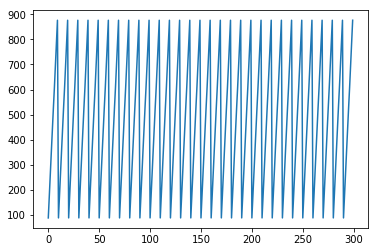

In [13]:
plt.plot(losses)